# PEAK DETECTION ALGORITHM WITH FUNCTION FROM: peakutils

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
import statistics
import neurokit2 as nk
from scipy.signal import butter, filtfilt, iirnotch, savgol_filter
import scipy.signal
import peakutils.peak

In [2]:
def butter_lowpass(cutoff, sample_rate, order=2):
    """
    The function returns the butter indexes for a butter lowpass filter. Github https://github.com/paulvangentcom/heartrate_analysis_python/tree/0005e98618d8fc3378c03ab0a434b5d9012b1221 
    
    Input: cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; sample_rate-rate at which the signal was sampled.
    
    Ouput: butter indeces.

    """
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, sample_rate, order=2):
    """
    The function returns the butter indexes for a highpass filter. Github https://github.com/paulvangentcom/heartrate_analysis_python/tree/0005e98618d8fc3378c03ab0a434b5d9012b1221 
    
    Input: cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; sample_rate-rate at which the signal was sampled.
    
    Ouput: butter indeces.

    """
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [3]:
def filter_signal(data, cutoff, sample_rate, order=2, filtertype='lowpass'):
    """
    The function filters data in the frequency domain. 
    
    Input: data-signal data stored in an array; cutoff-frequency from which the values will be filtered out; order-stregnth of the filter; filtertype-type of filter:
        lowpass,highpass,bandpass,notch
    
    Ouput: filtered_data

    """
    
    if filtertype.lower() == 'lowpass':
        b, a = butter_lowpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'highpass':
        b, a = butter_highpass(cutoff, sample_rate, order=order)
    elif filtertype.lower() == 'bandpass':
        assert type(cutoff) == tuple or list or np.array, 'if bandpass filter is specified, \
cutoff needs to be array or tuple specifying lower and upper bound: [lower, upper].'
        b, a = butter_bandpass(cutoff[0], cutoff[1], sample_rate, order=order)
    elif filtertype.lower() == 'notch':
        b, a = iirnotch(cutoff, Q = 0.005, fs = sample_rate)
    else:
        raise ValueError('filtertype: %s is unknown, available are: \
lowpass, highpass, bandpass, and notch' %filtertype)

    filtered_data = filtfilt(b, a, data)
    
    return filtered_data

In [4]:
def remove_baseline_wander(data, sample_rate, cutoff=0.05):
    """
    The functions removes the signal's baseline.
    Input: data-signal stored in an array; sample_rate: sample rate in which the signal was sampled; cutoff-frequency frequency from which the values will be filtered out.
    Output: corrected signal.
    """
    return filter_signal(data = data, cutoff = cutoff, sample_rate = sample_rate,
                         filtertype='notch')

In [5]:
def cos_correction(signal):
    """
    The function removes a tenth of both ends from the signal by multiplying it by a half cosine function.
    Input: signal-index of data points to be corrected.
    Output: even signal with the corners diminished. 
    """
    length = len(signal) # We find the length of the signal.
    signal_10 = 0.01*length # We calculate the length of a tenth of the signal.
    signal_90 = length - signal_10 # We calculate the difference to know the tenth corresponding to the array's final end.
    step = (np.pi/2)/signal_10 # We find the number of values our cosine function needs to have.

    x = np.arange(0,np.pi/2,step) # We generate half a cosine function: start,stop,step
    y = np.cos(x)
    cos_end = y

    y = np.cos(x-1.57) # We shift it by pi so we can use it as a smoothening factor to apply to the values at the end of the signal.
    cos_init = y

    for index,value in enumerate(cos_init):
        signal[index] = signal[index]*value # We perform the multiplicatoin by the signal points and the cosine points.

    for value, index in zip((signal[int(signal_90):]), cos_end):
        signal[int(-index)] = value * index
    return signal

In [6]:
def scale_data(data, lower=0, upper=1024):
    """
    Subfunction from the enhance_peaks section. It allows to scale the data.
    Input: data-the signal, lower,upper-ranges that describe the scaling factor.
    Output: scaled signal. 
    """
    rng = np.max(data) - np.min(data)
    minimum = np.min(data)
    data = (upper - lower) * ((data - minimum) / rng) + lower
    return data

In [7]:
def enhance_peaks(hrdata, iterations=2):
    """
    The function squares the signal and, hence, enhances the peaks.
    Input: hrdata-the signal stored in an array; iterations-the times the signal is squared.
    Output: enhanced signal. 
    """
    scale_data(hrdata)
    for i in range(iterations):
        hrdata = np.power(hrdata, 2)
        hrdata = scale_data(hrdata)
    return hrdata 

In [8]:
def smoothing_window(signal):
    """
    The function creates a sliding window and it is used to smooth the signal out by an average mean.
    Input: signal-the signal stored in an array.
    Output: smoothened signal. 
    """
    #Define window size
    w=31
    #Define mask and store as an array
    mask=np.ones((1,w))/w
    mask=mask[0,:]

    #Convolve the mask with the raw data
    convolved_data=np.convolve(signal,mask,'same')
    return convolved_data

In [9]:
def _filtering(signal,rate):
    """
    Application of a sub-sequent filtering steps, based on the Pan-Tomkins peak scalation for subsequent peak detection. 
    Input: signal-the signal stored in an array; rate-the sampling frequency at which the signal was sampled.
    Output: filtered signal. 
    """
    cos_removed = cos_correction(signal) # We remove the points located at both ends of the signal.
    low = filter_signal(cos_removed,40, rate, order=3, filtertype='lowpass') # We apply a low-pass filter.
    high = filter_signal(low,5, rate, order=3, filtertype='highpass') # We apply a high-pass filter.
    smooth = smoothing_window(high) # We smooth the data.
    notch = filter_signal(smooth, 50, rate, filtertype='notch') # We apply a notch filter.
    remove = remove_baseline_wander(notch, rate) # We remove the signal's baseline.
    en = enhance_peaks(remove, iterations=4) # We enhance the signal twice to improve the following peak-detection.
    return en

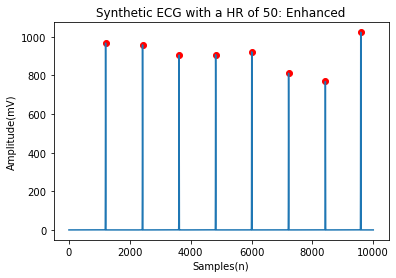

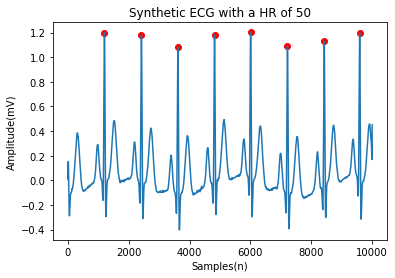

In [10]:
# We generate three different synthethic ECG signals. Library: neurokit2

ecg50 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=50) # No noise, HR:50
ecg80 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=80) # No noise, HR:80
ecg100 = nk.ecg_simulate(duration=10, sampling_rate=1000, heart_rate=100) # No noise, HR:100

filtered_50 = _filtering(ecg50,1000)

peaks_50 = peakutils.peak.indexes(np.array(filtered_50),
thres = 7.0/max(filtered_50), min_dist=2)

signal, = plt.plot(filtered_50)
plt.title('Synthetic ECG with a HR of 50: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
x_data = signal.get_xdata()
y_values = []
for point in peaks_50:
    value = np.interp(point, x_data, filtered_50)
    y_values.append(value)
plt.scatter(peaks_50,y_values,marker='o',c='red')
plt.show()

signal, = plt.plot(ecg50)
plt.title('Synthetic ECG with a HR of 50')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
x_data = signal.get_xdata()
y_values = []
for point in peaks_50:
    value = np.interp(point, x_data, ecg50)
    y_values.append(value)
plt.scatter(peaks_50,y_values,marker='o',c='red')
plt.show()

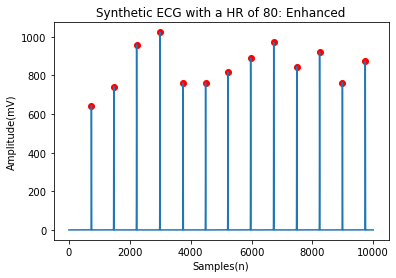

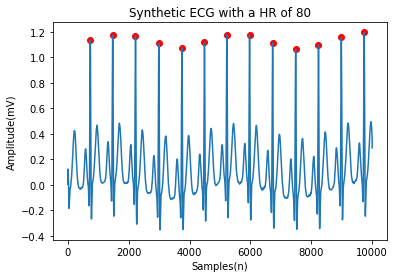

In [11]:
filtered_80 = _filtering(ecg80,1000)

peaks_80 = peakutils.peak.indexes(np.array(filtered_80),
thres = 7.0/max(filtered_80), min_dist=2)

signal, = plt.plot(filtered_80)
x_data = signal.get_xdata()
plt.title('Synthetic ECG with a HR of 80: Enhanced')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
y_values = []
for point in peaks_80:
    value = np.interp(point, x_data, filtered_80)
    y_values.append(value)
plt.scatter(peaks_80,y_values,marker='o',c='red')
plt.show()

signal, = plt.plot(ecg80)
x_data = signal.get_xdata()
plt.title('Synthetic ECG with a HR of 80')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
y_values = []
for point in peaks_80:
    value = np.interp(point, x_data, ecg80)
    y_values.append(value)
plt.scatter(peaks_80,y_values,marker='o',c='red')
plt.show()

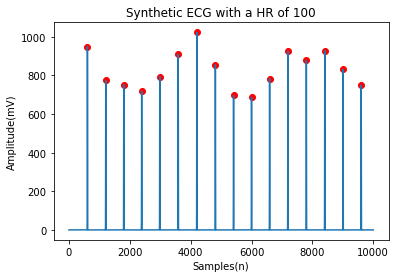

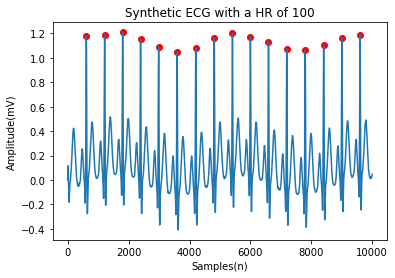

In [12]:
filtered_100 = _filtering(ecg100,1000)

peaks_100 = peakutils.peak.indexes(np.array(filtered_100),
thres = 7.0/max(filtered_100), min_dist=2)

signal, = plt.plot(filtered_100)
x_data = signal.get_xdata()
plt.title('Synthetic ECG with a HR of 100')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
y_values = []
for point in peaks_100:
    value = np.interp(point, x_data, filtered_100)
    y_values.append(value)
plt.scatter(peaks_100,y_values,marker='o',c='red')
plt.show()

signal, = plt.plot(ecg100)
x_data = signal.get_xdata()
plt.title('Synthetic ECG with a HR of 100')
plt.xlabel('Samples(n)')
plt.ylabel('Amplitude(mV)')
y_values = []
for point in peaks_100:
    value = np.interp(point, x_data, ecg100)
    y_values.append(value)
plt.scatter(peaks_100,y_values,marker='o',c='red')
plt.show()